In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================
# -- Copied from lecture
%load_ext autoreload
%config IPCompleter.greedy=True
%autoreload 1
%aimport util
import logging

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from util import util

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)


# Load the datasets
data_train = util.load_dataset('7_gecco2019_train_water_quality.csv')
data_val = util.load_dataset('8_gecco2019_valid_water_quality.csv')
data_test = util.load_dataset('6_gecco2019_test_water_quality.csv')

# Fill missing values
data_train = util.impute_missing_values(data_train)
data_val = util.impute_missing_values(data_val)
data_test = util.impute_missing_values(data_test)

# Get the feature columns
feature_columns = util.get_feature_columns(data_train)

# Distribution and Detrending

## Autocorrelation Plot
Let's again have a look at the autocorrelation plot for the entire dataset.

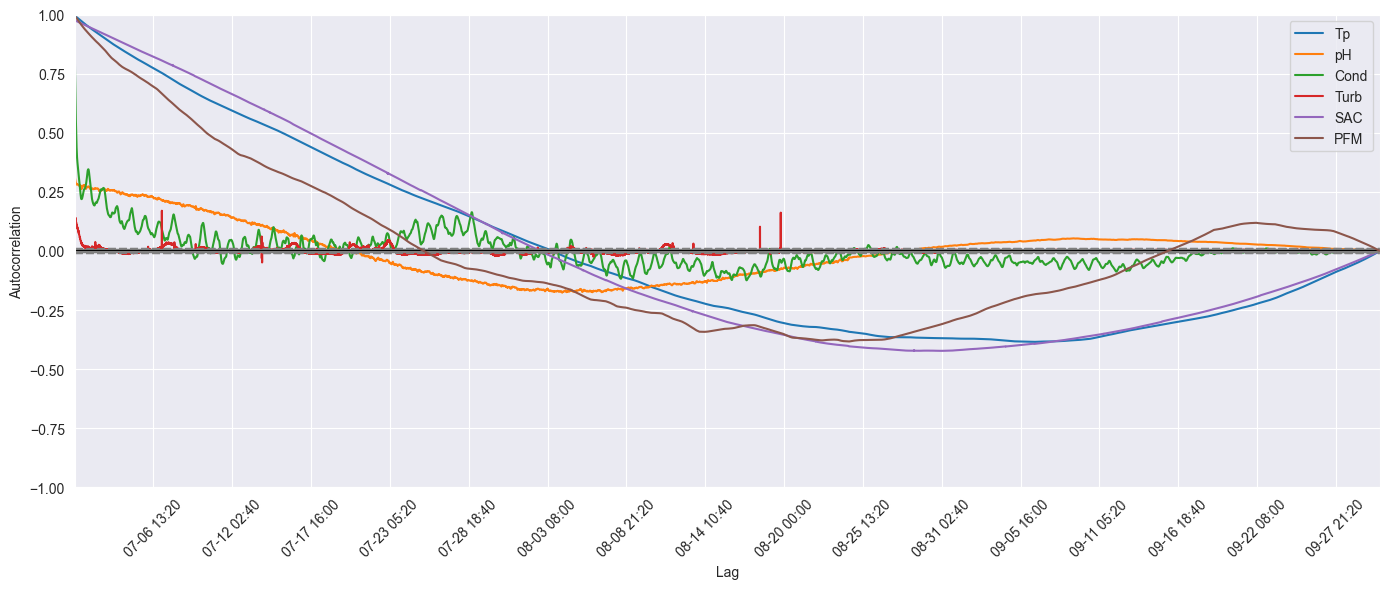

In [2]:
# Prepare the data for the autocorrelation plot
sample_delta = (data_train.index[1] - data_train.index[0])
data_autocorrelation = [data_train[c] for c in feature_columns]

# Plot the autocorrelation for each feature
util.plot_multiple_autocorrelations(data_autocorrelation, figsize=(figsize[0], 6))

## Visualizing the Trends for each Feature

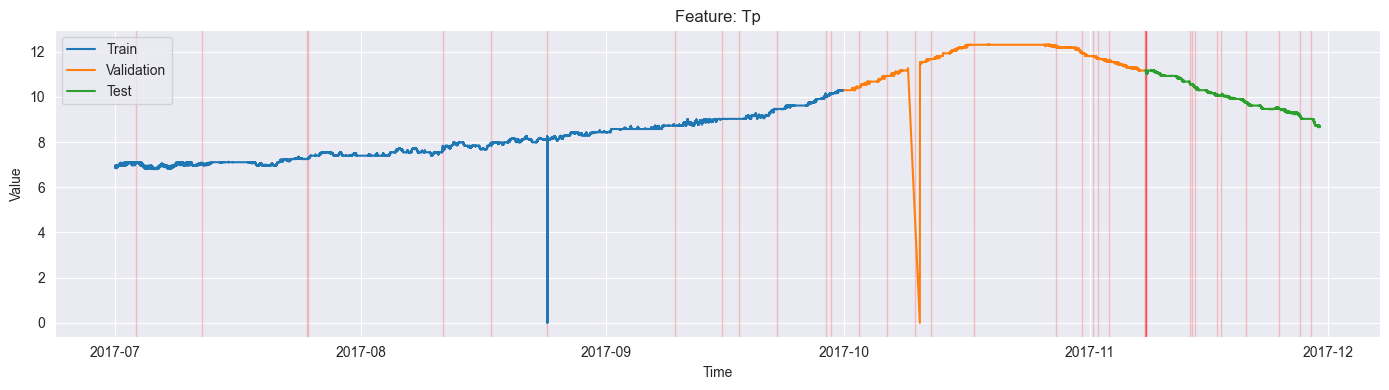

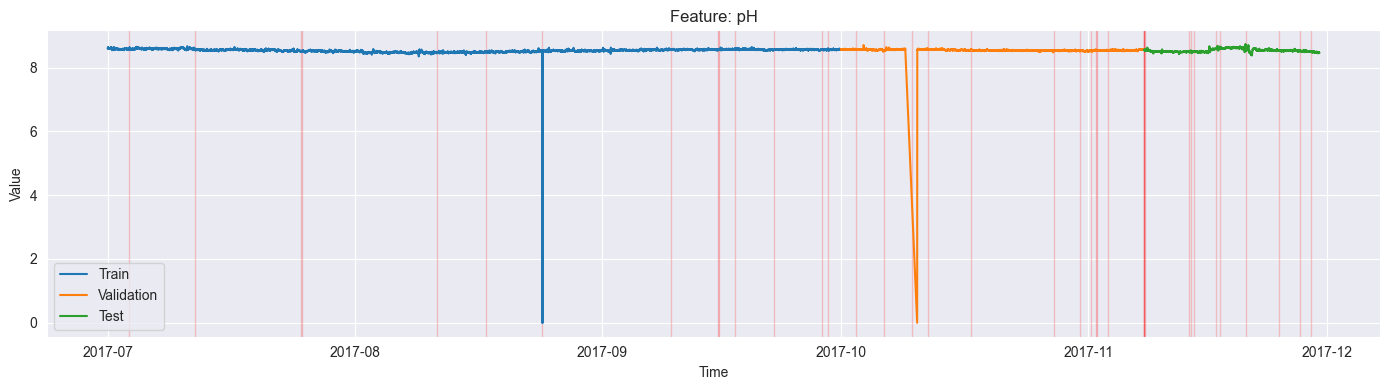

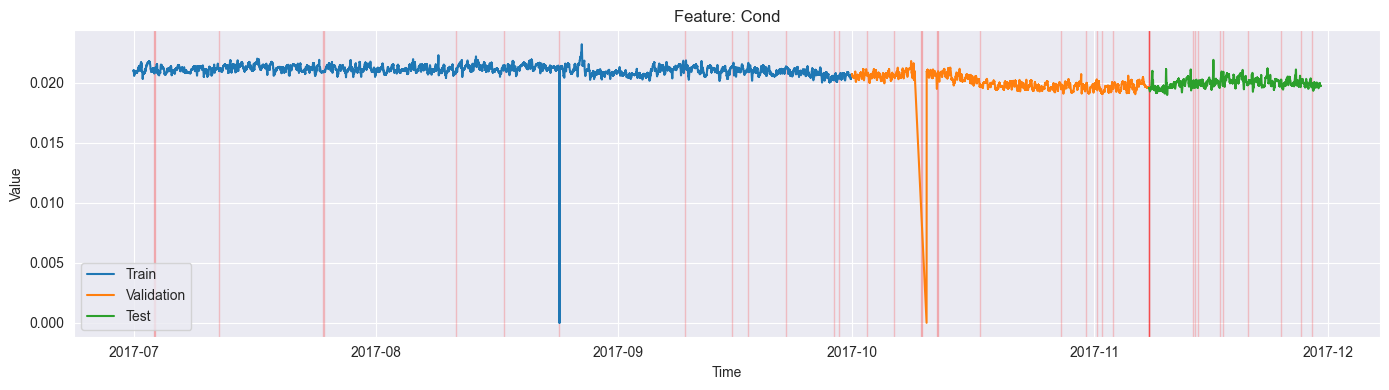

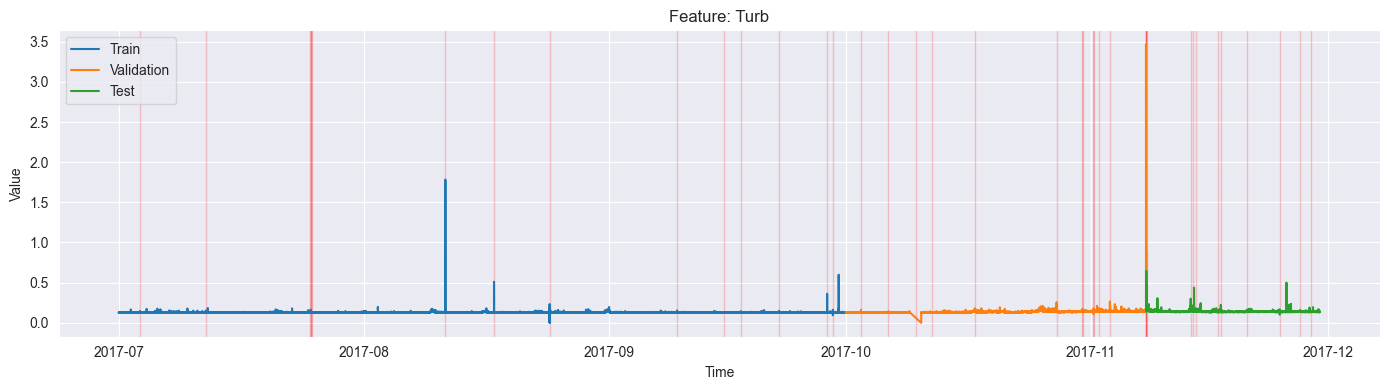

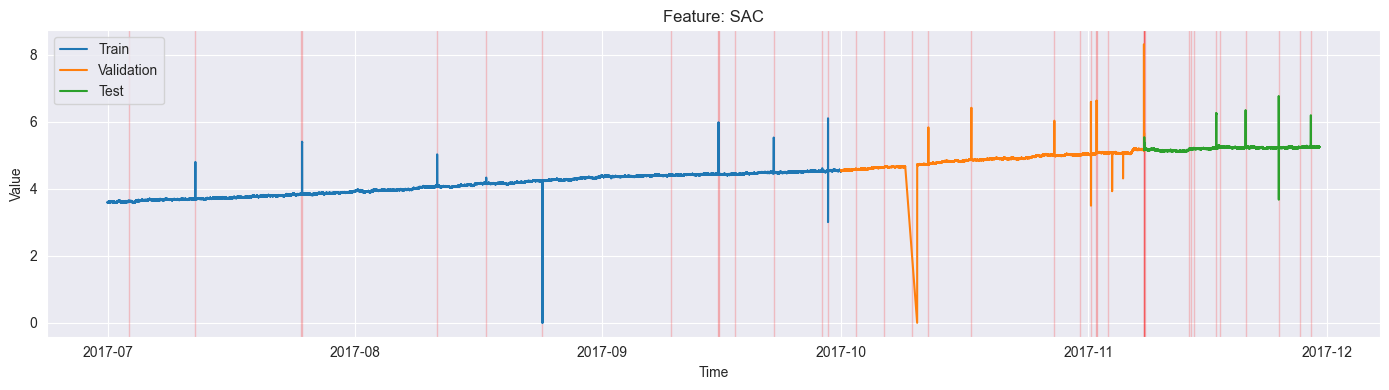

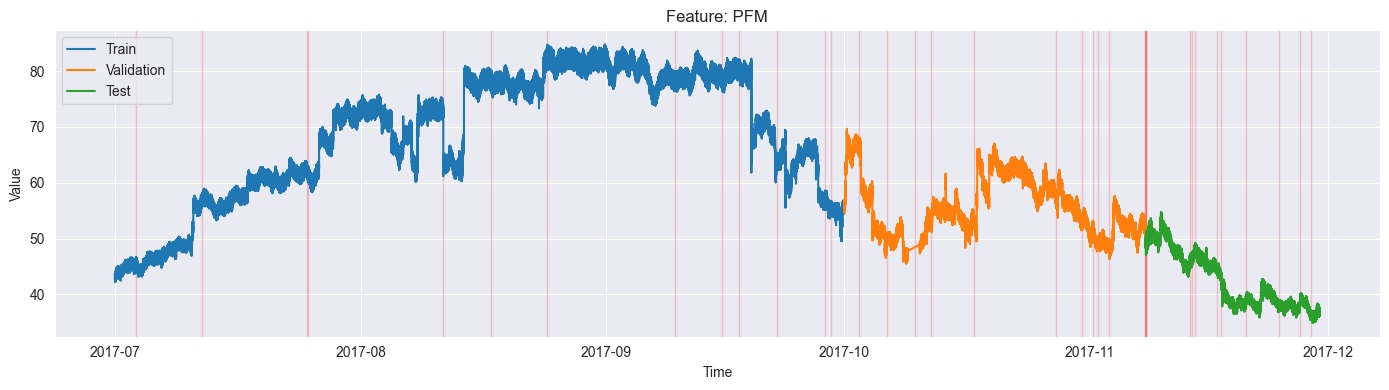

In [3]:
# Create a dictionary for easy iteration over the datasets
datasets = {
    'Train': data_train,
    'Validation': data_val,
    'Test': data_test
}

# Plot each feature over the full timespan and add red spans for contamination events
for feature in feature_columns:
    plt.figure(figsize=figsize)

    # Plot each dataset's feature
    for label, df in datasets.items():
        # Plot the feature values using the DataFrame index as x-axis.
        plt.plot(df[feature], label=label)

        # Highlight contamination periods
        util.highlight_contamination(df)

    plt.title(f"Feature: {feature}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Visualizing the Distribution of each Feature

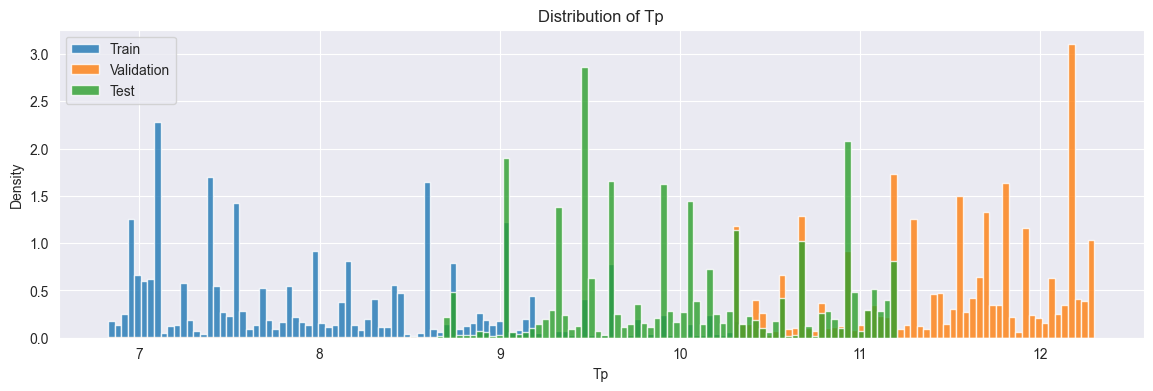

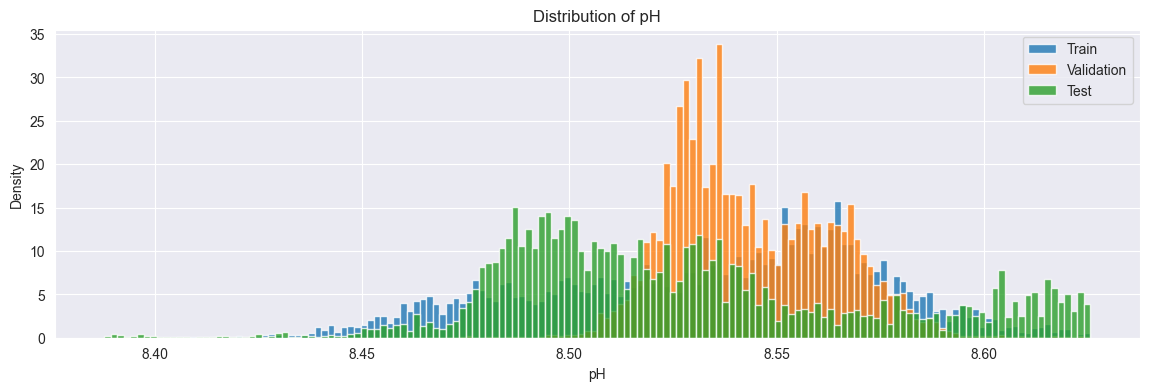

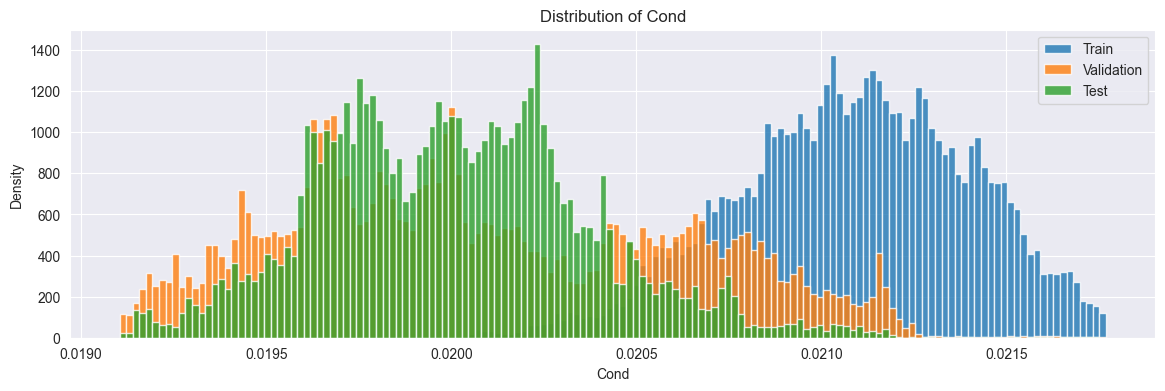

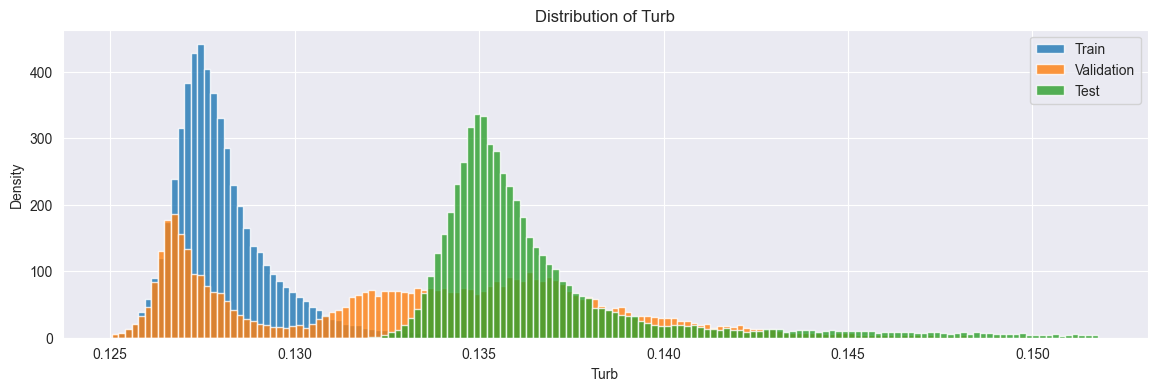

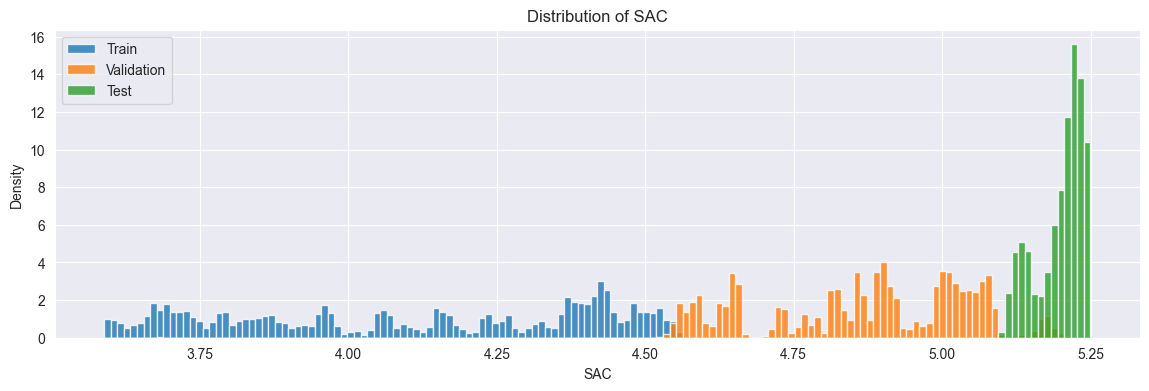

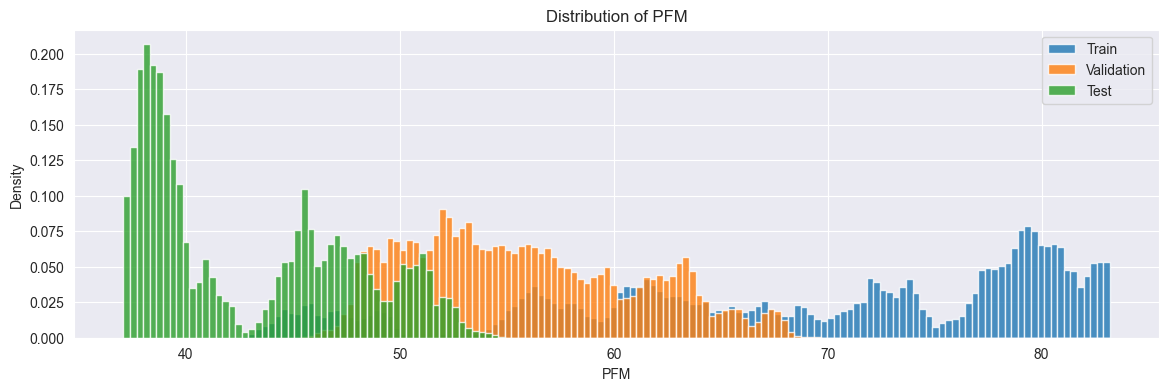

In [4]:
for feature in feature_columns:
    plt.figure(figsize=figsize)

    # Determine the overall minimum and maximum values from all datasets
    all_data = np.concatenate([data_train[feature], data_val[feature], data_test[feature]])

    # Remove outliers
    lower_threshold = np.percentile(all_data, 1)
    upper_threshold = np.percentile(all_data, 99)
    all_data = all_data[(all_data > lower_threshold) & (all_data < upper_threshold)]

    # Create 150 bins
    min_val, max_val = all_data.min(), all_data.max()
    bins = np.linspace(min_val, max_val, 151)

    # Set the x-axis limits
    margin = 0.05 * (max_val - min_val)  # 1% margin on each side
    plt.xlim(min_val - margin, max_val + margin)

    # Plot each dataset's feature
    for label, df in datasets.items():
        # Plot normalized histograms (density=True)
        plt.hist(df[feature], bins=bins, alpha=0.8, density=True, label=label)

    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Naive Trend Removal using Linear Regression

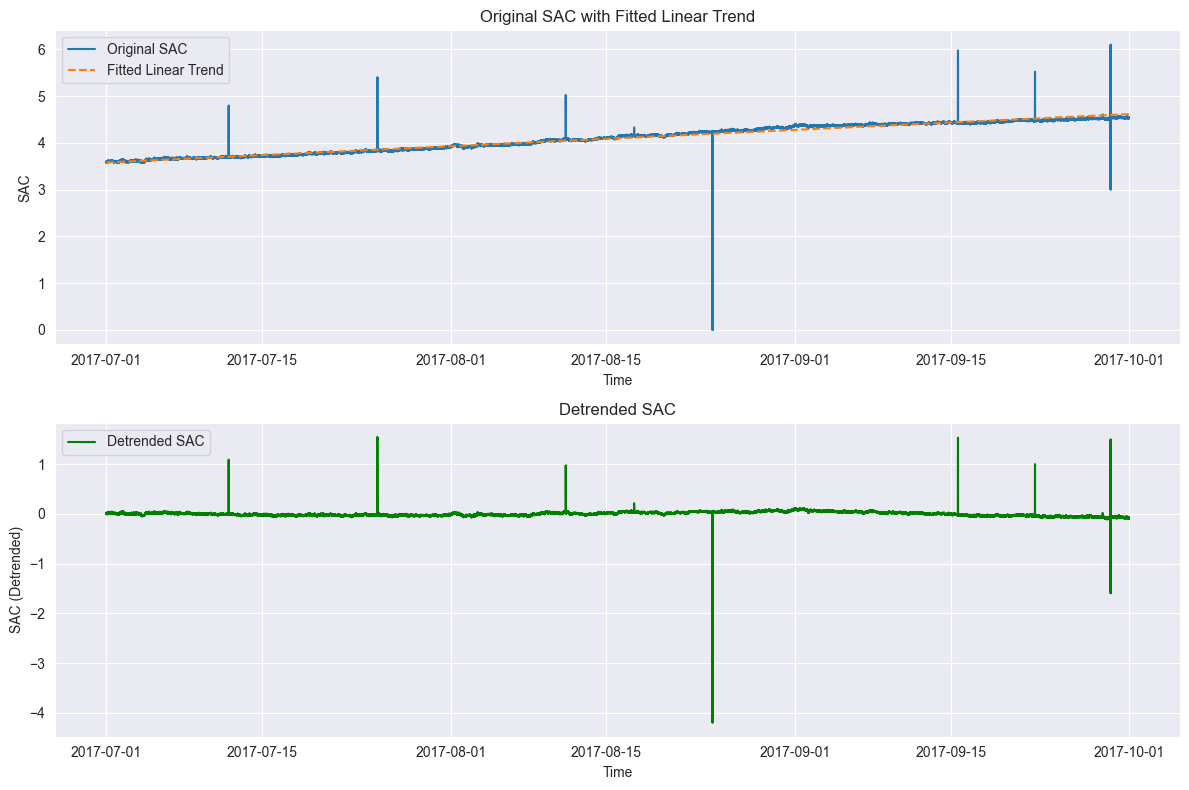

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assume df is your DataFrame with a DateTime index and a 'SAC' column

# Step 1: Create a numeric time variable (e.g., seconds elapsed since the start)
df = data_train.interpolate(method='linear', axis=0)
df['time_num'] = (df.index - df.index[0]).total_seconds()

# Step 2: Fit a linear regression model to 'SAC' over time
X = df[['time_num']]
y = df['SAC']
lr = LinearRegression()
lr.fit(X, y)

# Get the fitted trend
df['trend'] = lr.predict(X)

# Step 3: Remove the trend (detrend the data)
df['SAC_detrended'] = df['SAC'] - df['trend']

# Step 4: Plot the results
plt.figure(figsize=(12, 8))

# Plot original data and the fitted trend
plt.subplot(2, 1, 1)
plt.plot(df.index, df['SAC'], label='Original SAC')
plt.plot(df.index, df['trend'], label='Fitted Linear Trend', linestyle='--')
plt.title('Original SAC with Fitted Linear Trend')
plt.xlabel('Time')
plt.ylabel('SAC')
plt.legend()

# Plot detrended data
plt.subplot(2, 1, 2)
plt.plot(df.index, df['SAC_detrended'], label='Detrended SAC', color='green')
plt.title('Detrended SAC')
plt.xlabel('Time')
plt.ylabel('SAC (Detrended)')
plt.legend()

plt.tight_layout()
plt.show()

We could now continue and do similar things for the other features. For example, we could remove the sine wave trend from the `Tp` feature using Harmonic Regression. But this approach is limited to our visual observations and may not reflect the real underlying trend in the data.

## Detrending using a Moving Average

In [6]:
# Define a reasonable window size (4 hours)
window_size = 4 * 60

# Apply a moving average detrending to the dataset
data_train_detrended = util.apply_detrending(data_train, window_size=window_size)
data_val_detrended = util.apply_detrending(data_val, window_size=window_size)
data_test_detrended = util.apply_detrending(data_test, window_size=window_size)

## Visualizing the Detrended Features

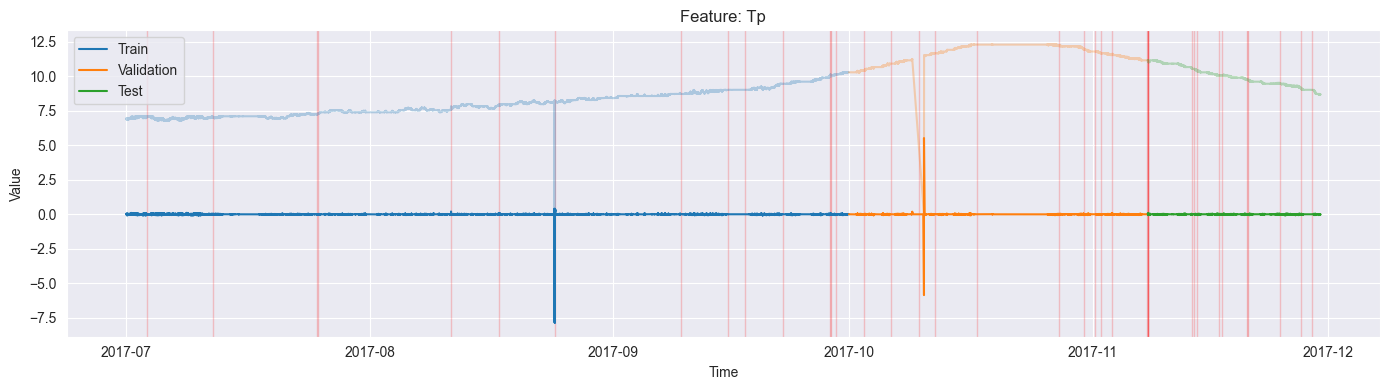

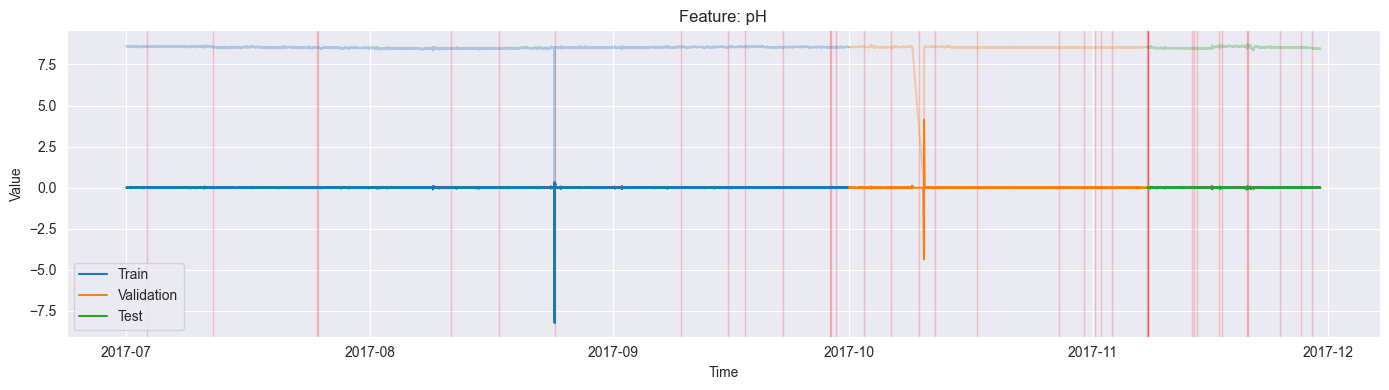

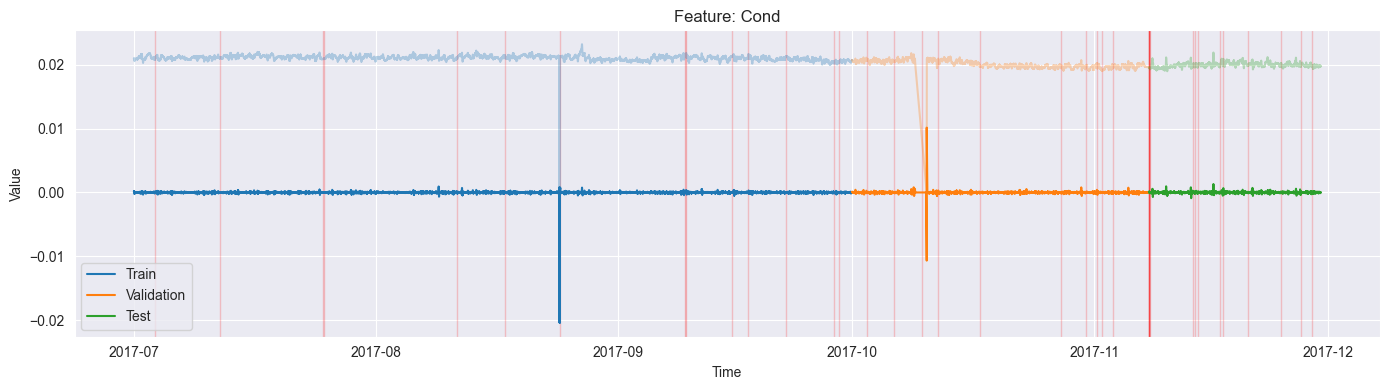

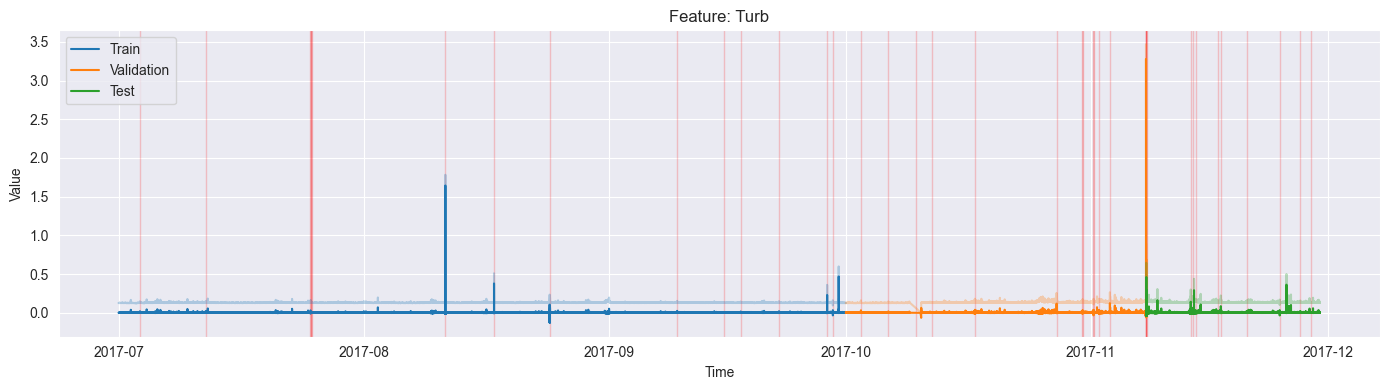

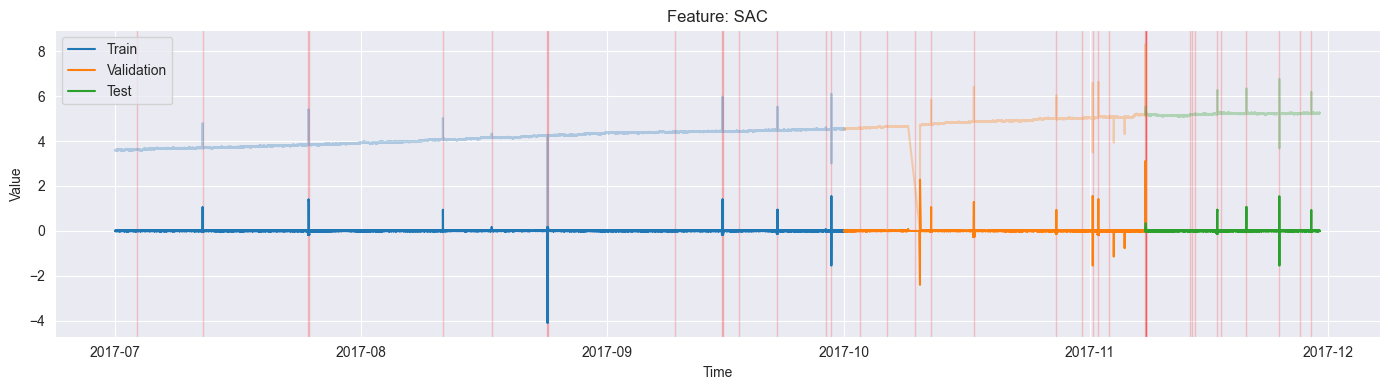

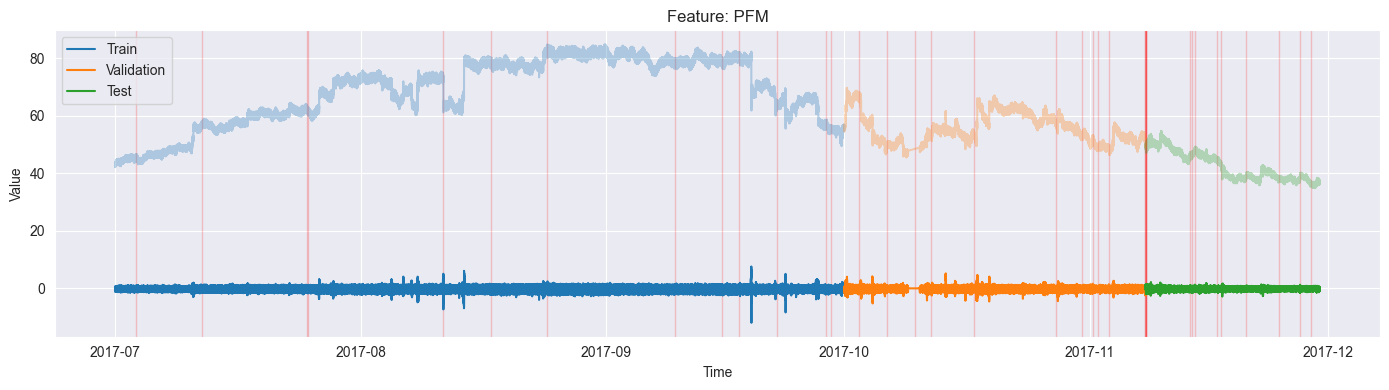

In [7]:
# Create a dictionary for easy iteration over the datasets for the detrending analysis
datasets_detrended = {
    'Train': ('C0', data_train, data_train_detrended),
    'Validation': ('C1', data_val, data_val_detrended),
    'Test': ('C2', data_test, data_test_detrended)
}

# Plot each feature over the full timespan and add red spans for contamination events
for feature in feature_columns:
    plt.figure(figsize=figsize)

    # Plot each dataset's feature
    for label, dfs in datasets_detrended.items():
        color, df, detrended_df = dfs

        # Plot the feature values using the DataFrame index as x-axis.
        plt.plot(detrended_df[feature], label=label, color=color)
        plt.plot(df[feature], color=color, alpha=0.3)

        # Highlight contamination periods
        util.highlight_contamination(df)

    plt.title(f"Feature: {feature}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Visualizing the Detrended Distribution of each Feature

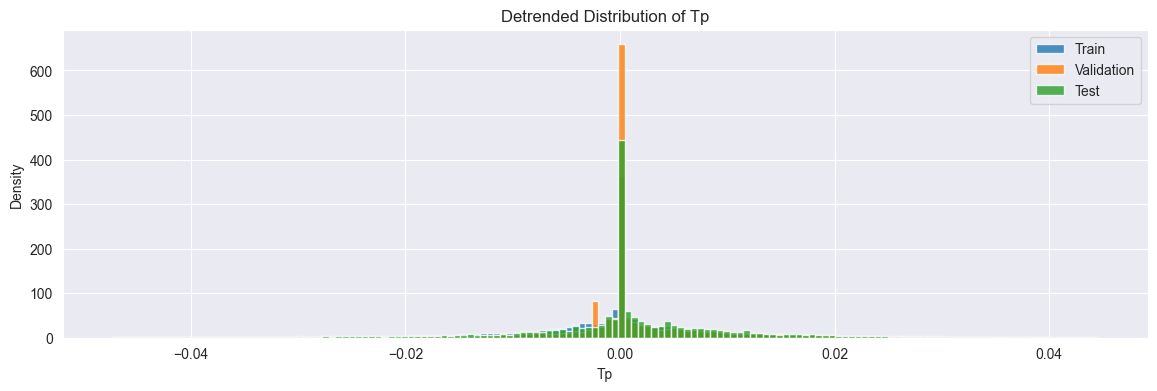

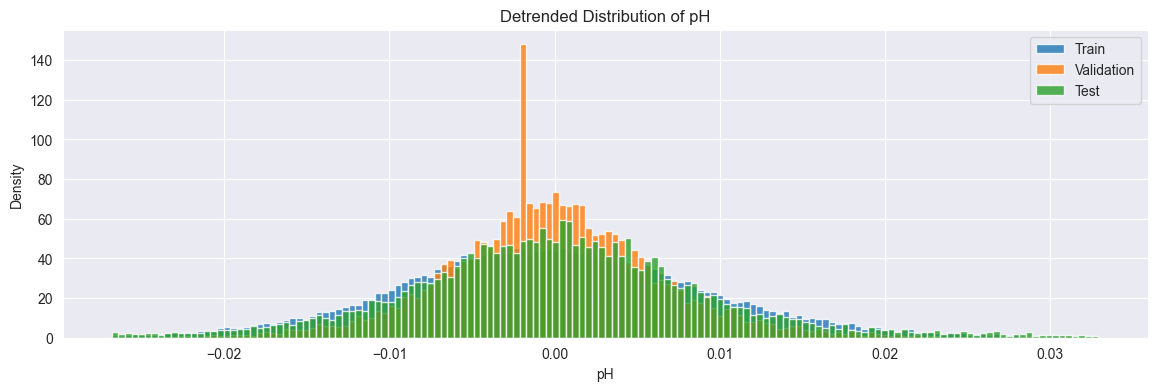

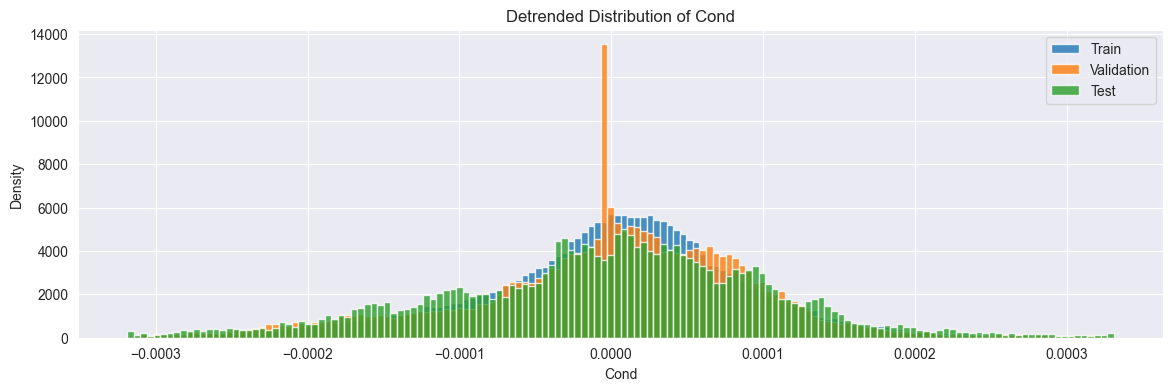

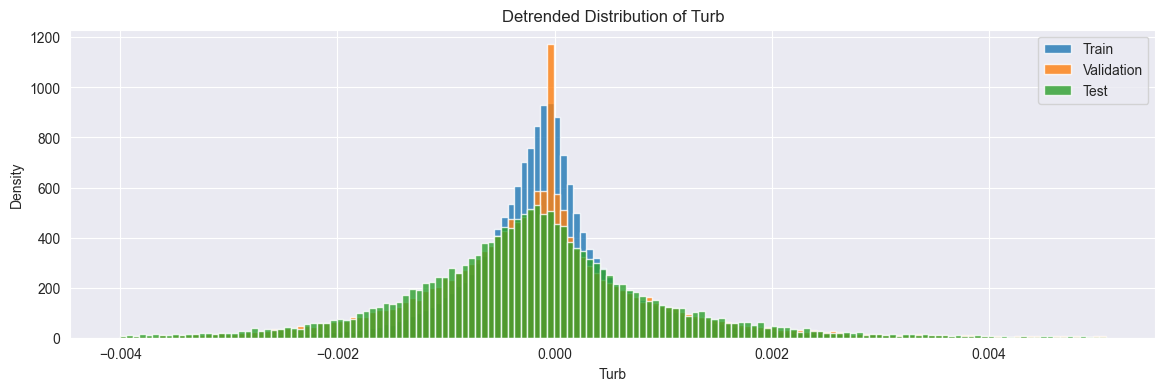

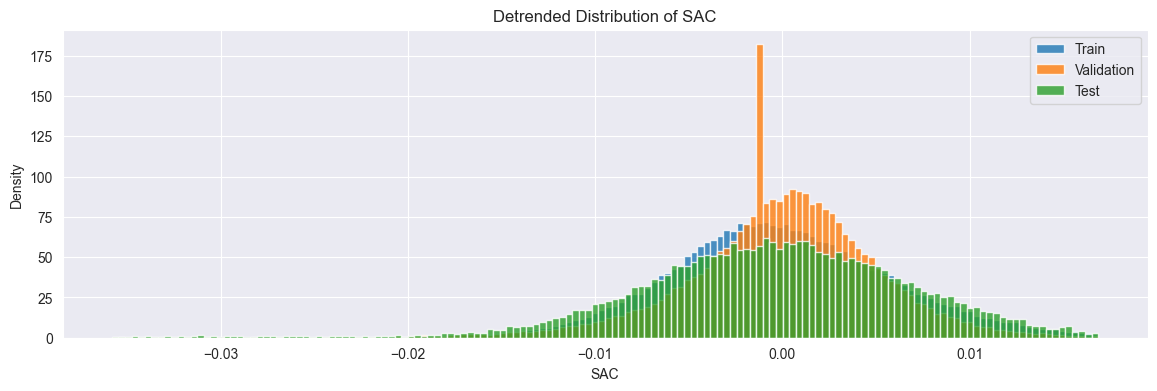

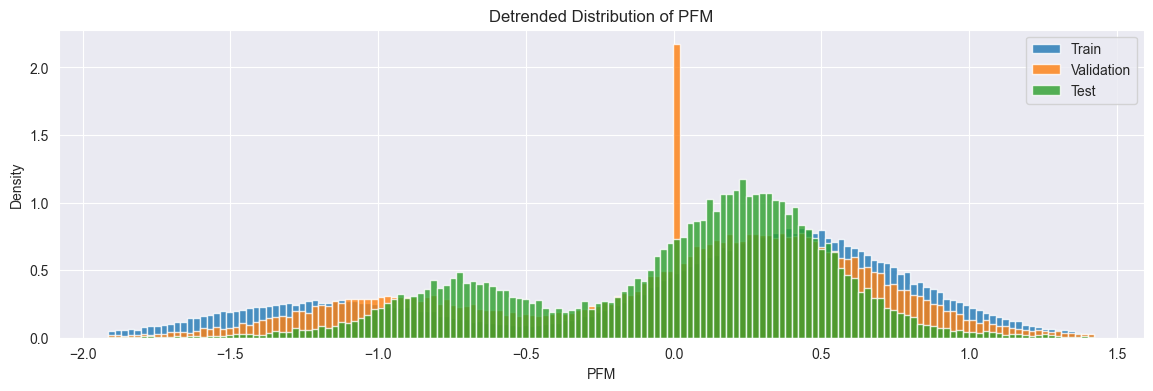

In [8]:
for feature in feature_columns:
    plt.figure(figsize=figsize)

    # Determine the overall minimum and maximum values from all datasets
    all_data = np.concatenate([data_train_detrended[feature], data_val_detrended[feature], data_test_detrended[feature]])

    # Remove outliers
    lower_threshold = np.percentile(all_data, 1)
    upper_threshold = np.percentile(all_data, 99)
    all_data = all_data[(all_data > lower_threshold) & (all_data < upper_threshold)]

    # Create 150 bins
    min_val, max_val = all_data.min(), all_data.max()
    bins = np.linspace(min_val, max_val, 151)

    # Set the x-axis limits
    margin = 0.05 * (max_val - min_val)  # 1% margin on each side
    plt.xlim(min_val - margin, max_val + margin)

    # Plot each dataset's feature
    for label, dfs in datasets_detrended.items():
        color, df, detrended_df = dfs

        # Plot normalized histograms (density=True)
        plt.hist(detrended_df[feature], bins=bins, alpha=0.8, density=True, label=label)

    plt.title(f'Detrended Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Autocorrelation Plot for Detrended Data

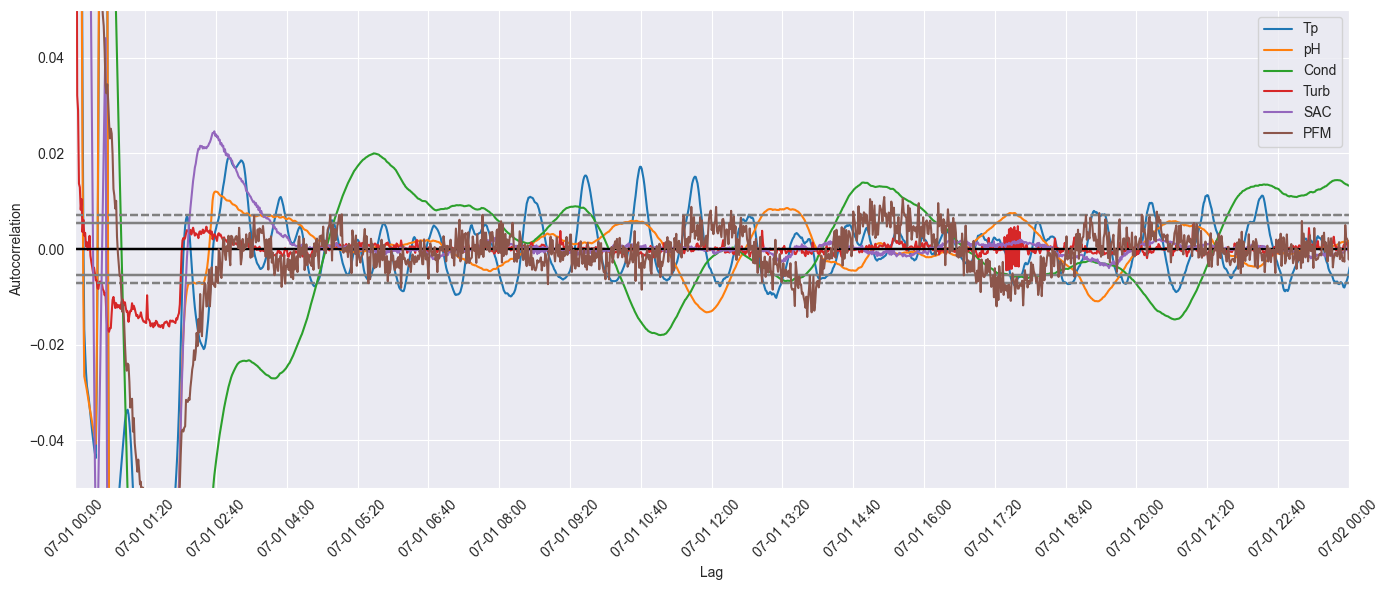

In [9]:
# Prepare the data for the autocorrelation plot
sample_delta = (data_train_detrended.index[1] - data_train_detrended.index[0])
data_autocorrelation = [data_train_detrended[c] for c in feature_columns]

# Plot the autocorrelation for each feature
util.plot_multiple_autocorrelations(data_autocorrelation, pd.Timedelta(days=1) / sample_delta, figsize=(figsize[0], 6), ylim=(-0.05, 0.05))

## Choosing the Ideal Window Size
The choice of the window size is critical for the success of the detrending approach.

A small sliding window tends to follow the data too closely. It captures a lot of the short-term noise or fluctuations, which means that the estimated trend might still contain much of the high-frequency variation. This can make it difficult to isolate the true underlying trend, resulting in a high-variance, low-bias estimate.

On the other hand, a very large sliding window provides a smoother trend estimate by averaging over many points. While this reduces noise (lower variance), it can oversmooth the data and introduce lag. As a result, important local changes or rapid shifts in the trend may be obscured, leading to a high-bias, low-variance estimate.

The final window size of 4 hours was chosen based on the results of the previous analysis. It turned out to be a good compromise between the two extremes by providing a balance between noise reduction and trend isolation.

